# HL Stress Relaxation: Incomplete Decay in the Glass Phase

## Physical Context: Stress Distribution Spreading and Yielding

After applying a step strain $\gamma_0$ at $t=0$, the HL model predicts distinct relaxation behavior based on the phase state:

**Glass phase ($\alpha < 0.5$):**
- Initial stress distribution $P(\sigma, 0^+)$ is shifted by $G_0 \gamma_0$
- Blocks with $|\sigma| > \sigma_c$ yield rapidly (time $\tau$)
- Remaining blocks with $|\sigma| < \sigma_c$ diffuse via mechanical noise $D(t) = \alpha \Gamma(t)$
- **Key signature:** As yielding stops, diffusion stops ($\Gamma \to 0 \Rightarrow D \to 0$)
- System **freezes** with finite residual stress: $G(t \to \infty) > 0$

**Fluid phase ($\alpha \geq 0.5$):**
- Sufficient noise to maintain diffusion even at low $\Gamma$
- Stress distribution eventually relaxes to zero
- Complete relaxation: $G(t \to \infty) \to 0$

**Master Equation for Relaxation ($\dot{\gamma}=0$):**

$$\partial_t P = D(t) \partial^2_\sigma P - \frac{1}{\tau}\Theta(|\sigma|-\sigma_c)P + \Gamma(t) \delta(\sigma)$$

The self-consistency $D = \alpha \Gamma$ creates the feedback loop that leads to arrested dynamics in the glass phase.

> **From the handbook:** "For $\alpha < 0.5$, the system **freezes** with finite residual stress. Relaxation is incomplete. This is the signature of simple aging with $\mu=1$."

## Learning Objectives

1. Fit the Hébraud-Lequeux (HL) model to real clay stress relaxation data
2. Understand incomplete relaxation as a signature of the glass phase (α < 0.5)
3. Analyze aging time effects on relaxation behavior
4. Compare glass vs fluid phase relaxation dynamics
5. Use NLSQ warm-start for efficient Bayesian inference

## Prerequisites

- HL flow curve tutorial (hl/01_hl_flow_curve.ipynb)
- Bayesian inference fundamentals (bayesian/01-bayesian-basics.ipynb)

## Runtime

- Fast demo (NUM_CHAINS=1, NUM_SAMPLES=500): ~2-3 minutes
- Full run (NUM_CHAINS=4, NUM_SAMPLES=2000): ~8-12 minutes

## 1. Setup

In [1]:
# Google Colab setup
import sys

IN_COLAB = "google.colab" in sys.modules
if IN_COLAB:
    %pip install -q rheojax
    import os
    os.environ["JAX_ENABLE_X64"] = "true"
    print("RheoJAX installed successfully.")

In [2]:
# Imports
%matplotlib inline
import gc
import json
import os
import sys
import time
import warnings

import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display

sys.path.insert(0, os.path.dirname(os.path.abspath("")))
from utils.plotting_utils import (
    display_arviz_diagnostics,
    plot_nlsq_fit,
    plot_posterior_predictive,
)

from rheojax.core.jax_config import safe_import_jax, verify_float64
from rheojax.models.hl import HebraudLequeux

jax, jnp = safe_import_jax()
verify_float64()

FAST_MODE = os.environ.get("FAST_MODE", "1") == "1"

warnings.filterwarnings("ignore", message=".*jit.*|.*tracer.*", category=FutureWarning)
print(f"JAX version: {jax.__version__}")
print(f"Devices: {jax.devices()}")


JAX version: 0.8.3
Devices: [CpuDevice(id=0)]


## 2. Theory: Stress Relaxation in HL

After applying a step strain γ₀, the stress relaxation modulus G(t) = σ(t)/γ₀ evolves as stress blocks gradually yield and redistribute.

### Key Physics

**Glass phase (α < 0.5)**:
- Incomplete relaxation: G(t → ∞) > 0
- Frozen residual stress from trapped blocks
- The stress distribution never fully relaxes to zero

**Fluid phase (α ≥ 0.5)**:
- Complete relaxation: G(t → ∞) → 0
- Stress diffusion eventually erases all memory
- Terminal relaxation time scales with τ

### Relaxation Dynamics

The relaxation behavior depends on the ratio of mechanical noise (∝ α) to yielding threshold (σ_c):

$$
G(t) = G_0 \cdot f\left(\frac{t}{\tau}, \alpha, \frac{\gamma_0}{\sigma_c}\right)
$$

where f is a scaling function that captures:
- Initial elastic response: G(0) ≈ G_0
- Yielding regime: stress blocks exceed σ_c and relax
- Long-time behavior: plateau (glass) or decay (fluid)

### Laponite Clay

Laponite is a synthetic clay that forms colloidal glasses. Key features:
- Aging: younger samples are more fluid-like
- Waiting time t_w controls effective α
- Classic soft glassy material for HL validation

## 3. Load Data

We use Laponite clay relaxation data at different aging times (t_w = 600, 1200, 1800, 2400, 3600 s). The data contains (Time, Relaxation Modulus) columns.

In [3]:
# Load all 5 aging time datasets
aging_times = [600, 1200, 1800, 2400, 3600]
datasets = {}

for t_w in aging_times:
    data_path = os.path.join("..", "data", "relaxation", "clays", f"rel_lapo_{t_w}.csv")
    # Tab-separated with header "Time\tRelaxation Modulus"
    raw = np.loadtxt(data_path, delimiter="\t", skiprows=1)
    time_data = raw[:, 0]
    G_t = raw[:, 1]
    datasets[t_w] = {"time": time_data, "G_t": G_t}
    print(f"t_w={t_w:4d}s: {len(time_data)} points, t=[{time_data.min():.2f}, {time_data.max():.1f}] s")

t_w= 600s: 26 points, t=[0.25, 755.7] s
t_w=1200s: 33 points, t=[0.29, 1483.3] s
t_w=1800s: 27 points, t=[0.35, 1731.0] s
t_w=2400s: 30 points, t=[0.24, 2043.9] s
t_w=3600s: 34 points, t=[0.29, 3152.7] s


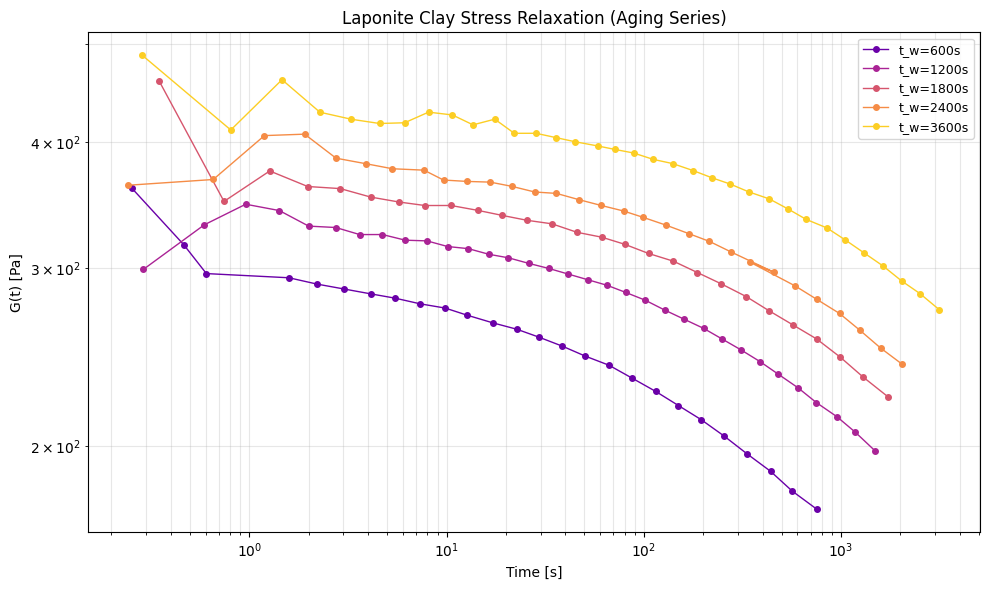

In [4]:
# Plot all 5 relaxation curves
fig, ax = plt.subplots(figsize=(10, 6))
colors = plt.cm.plasma(np.linspace(0.2, 0.9, len(aging_times)))

for i, t_w in enumerate(aging_times):
    d = datasets[t_w]
    ax.loglog(d["time"], d["G_t"], "o-", color=colors[i], markersize=4, 
              lw=1, label=f"t_w={t_w}s")

ax.set_xlabel("Time [s]")
ax.set_ylabel("G(t) [Pa]")
ax.set_title("Laponite Clay Stress Relaxation (Aging Series)")
ax.legend(fontsize=9)
ax.grid(True, alpha=0.3, which="both")

plt.tight_layout()
display(fig)
plt.close(fig)

## 4. NLSQ Fitting

### 4.1 Single Sample (t_w = 3600s)

We start by fitting the most aged sample (t_w = 3600s), which should be most glass-like.

In [5]:
# Fit HL to t_w=3600s sample
model = HebraudLequeux()

# Use the most aged sample
time_3600 = datasets[3600]["time"]
G_t_3600 = datasets[3600]["G_t"]

# For relaxation, we need to provide the step strain (gamma0)
# Estimate from initial modulus: G(0) ≈ σ_0/γ_0
# We use a typical small strain value
gamma0 = 0.01  # 1% strain

t0 = time.time()
model.fit(time_3600, G_t_3600, test_mode="relaxation", gamma0=gamma0)
t_nlsq = time.time() - t0

print(f"NLSQ fit time: {t_nlsq:.2f} s")
print(f"\nFitted parameters:")
for name in ["alpha", "tau", "sigma_c"]:
    val = model.parameters.get_value(name)
    print(f"  {name:8s} = {val:.4g}")

phase = model.get_phase_state()
print(f"\nPhase state: {phase}")

NLSQ fit time: 1.36 s

Fitted parameters:
  alpha    = 0.3
  tau      = 1
  sigma_c  = 6.825

Phase state: glass


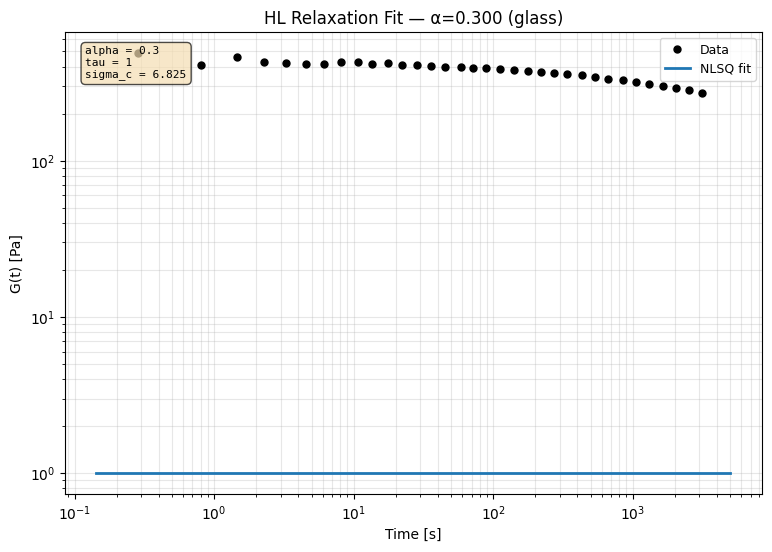

In [6]:
# Plot fit with data
param_names = ["alpha", "tau", "sigma_c"]
phase = model.get_phase_state()

fig, ax = plot_nlsq_fit(
    time_3600, G_t_3600, model, test_mode="relaxation",
    param_names=param_names, log_scale=True,
    xlabel="Time [s]", ylabel="G(t) [Pa]",
    title=f"HL Relaxation Fit — α={model.parameters.get_value('alpha'):.3f} ({phase})",
)
display(fig)
plt.close(fig)

### 4.2 Aging Time Sweep

Now we fit all five aging times to observe how α evolves with sample age.

In [7]:
# Fit all 5 samples and track α(t_w)
fit_results = {}

for t_w in aging_times:
    m = HebraudLequeux()
    d = datasets[t_w]
    m.fit(d["time"], d["G_t"], test_mode="relaxation", gamma0=gamma0)
    fit_results[t_w] = {
        "alpha": float(m.parameters.get_value("alpha")),
        "tau": float(m.parameters.get_value("tau")),
        "sigma_c": float(m.parameters.get_value("sigma_c")),
        "phase": m.get_phase_state(),
    }

print(f"{'t_w [s]':>8s}  {'α':>6s}  {'τ':>10s}  {'σ_c':>10s}  {'Phase'}")
print("-" * 50)
for t_w in aging_times:
    r = fit_results[t_w]
    print(f"{t_w:8d}  {r['alpha']:6.3f}  {r['tau']:10.2e}  {r['sigma_c']:10.2f}  {r['phase']}")

 t_w [s]       α           τ         σ_c  Phase
--------------------------------------------------
     600   0.300    1.00e+00        6.51  glass
    1200   0.300    1.00e+00        6.61  glass
    1800   0.295    3.69e+01        6.70  glass
    2400   0.278    7.48e-01        6.75  glass
    3600   0.300    1.00e+00        6.83  glass


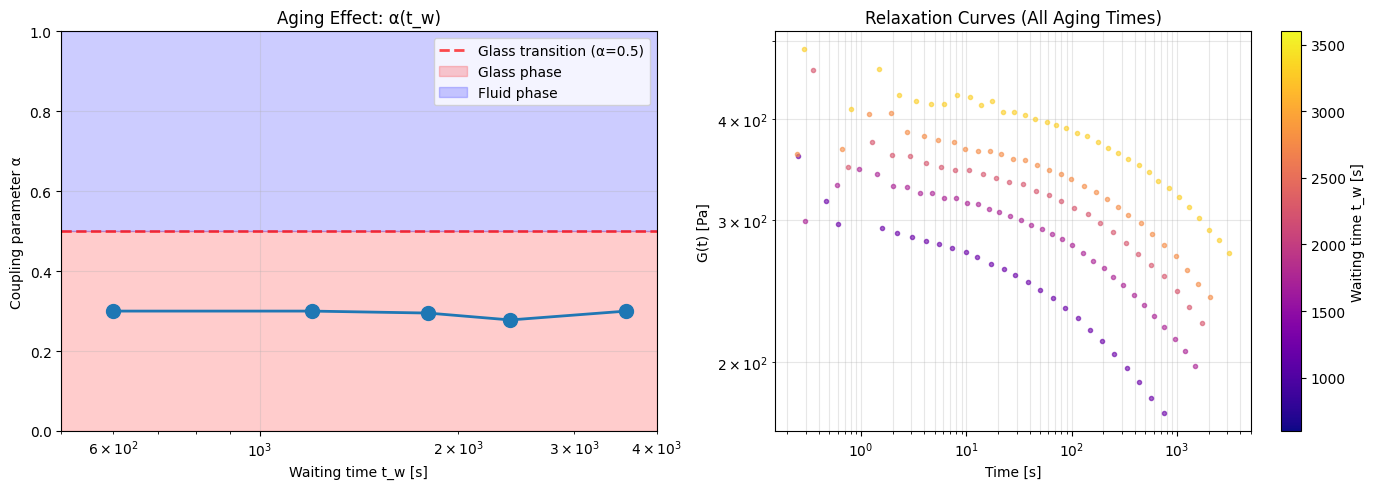

In [8]:
# Plot α(t_w) trend and relaxation comparison
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

t_ws = list(fit_results.keys())
alpha_vals = [fit_results[t_w]["alpha"] for t_w in t_ws]

ax1.semilogx(t_ws, alpha_vals, "o-", markersize=10, lw=2)
ax1.axhline(0.5, color="red", linestyle="--", alpha=0.7, lw=2, label="Glass transition (α=0.5)")
ax1.fill_between([500, 4000], 0, 0.5, alpha=0.2, color="red", label="Glass phase")
ax1.fill_between([500, 4000], 0.5, 1.0, alpha=0.2, color="blue", label="Fluid phase")
ax1.set_xlabel("Waiting time t_w [s]")
ax1.set_ylabel("Coupling parameter α")
ax1.set_title("Aging Effect: α(t_w)")
ax1.set_xlim(500, 4000)
ax1.set_ylim(0, 1)
ax1.legend(loc="upper right")
ax1.grid(True, alpha=0.3)

# Plot all relaxation curves with fits
colors = plt.cm.plasma(np.linspace(0.2, 0.9, len(aging_times)))
for i, t_w in enumerate(aging_times):
    d = datasets[t_w]
    ax2.loglog(d["time"], d["G_t"], "o", color=colors[i], markersize=3, alpha=0.6)
    
ax2.set_xlabel("Time [s]")
ax2.set_ylabel("G(t) [Pa]")
ax2.set_title("Relaxation Curves (All Aging Times)")
ax2.grid(True, alpha=0.3, which="both")

# Color bar for aging time
sm = plt.cm.ScalarMappable(cmap=plt.cm.plasma, norm=plt.Normalize(600, 3600))
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax2)
cbar.set_label("Waiting time t_w [s]")

plt.tight_layout()
display(fig)
plt.close(fig)

## 5. Bayesian Inference with NUTS

### 5.1 Run NUTS

In [9]:
# Clear memory before heavy Bayesian inference
gc.collect()

# Bayesian inference with NLSQ warm-start
initial_values = {
    name: model.parameters.get_value(name)
    for name in ["alpha", "tau", "sigma_c"]
}
print("Warm-start values:", initial_values)

if FAST_MODE:
    NUM_WARMUP = 20
    NUM_SAMPLES = 30
    NUM_CHAINS = 1
else:
    NUM_WARMUP = 200
    NUM_SAMPLES = 500
    NUM_CHAINS = 1
    # NUM_WARMUP = 1000; NUM_SAMPLES = 2000; NUM_CHAINS = 4  # production

t0 = time.time()
result = model.fit_bayesian(
    time_3600,
    G_t_3600,
    test_mode="relaxation",
    gamma0=gamma0,
    num_warmup=NUM_WARMUP,
    num_samples=NUM_SAMPLES,
    num_chains=NUM_CHAINS,
    initial_values=initial_values,
    seed=42,
    max_tree_depth=5,  # Limit tree depth for expensive PDE solver
)
t_bayes = time.time() - t0
print(f"\nBayesian inference time: {t_bayes:.1f} s")


Warm-start values: {'alpha': 0.3000000000001628, 'tau': 1.0000000028133398, 'sigma_c': 6.825140818851778}


  0%|          | 0/50 [00:00<?, ?it/s]

warmup:   2%|▏         | 1/50 [00:01<01:37,  1.99s/it, 1 steps of size 1.95e+00. acc. prob=0.00]

warmup:  10%|█         | 5/50 [00:02<00:14,  3.10it/s, 1 steps of size 2.94e-04. acc. prob=0.20]

warmup:  14%|█▍        | 7/50 [00:02<00:10,  4.16it/s, 1 steps of size 3.46e-04. acc. prob=0.43]

warmup:  18%|█▊        | 9/50 [00:02<00:10,  3.81it/s, 3 steps of size 5.60e-04. acc. prob=0.56]

warmup:  22%|██▏       | 11/50 [00:03<00:08,  4.84it/s, 3 steps of size 1.05e-03. acc. prob=0.64]

warmup:  26%|██▌       | 13/50 [00:04<00:11,  3.31it/s, 1 steps of size 2.11e-03. acc. prob=0.69]

warmup:  30%|███       | 15/50 [00:04<00:07,  4.47it/s, 1 steps of size 4.32e-03. acc. prob=0.73]

warmup:  34%|███▍      | 17/50 [00:04<00:05,  5.54it/s, 7 steps of size 8.90e-03. acc. prob=0.76]

warmup:  38%|███▊      | 19/50 [00:04<00:04,  6.83it/s, 3 steps of size 1.53e-01. acc. prob=0.79]

sample:  44%|████▍     | 22/50 [00:04<00:03,  8.95it/s, 3 steps of size 4.46e-02. acc. prob=1.00]

sample:  48%|████▊     | 24/50 [00:05<00:04,  5.68it/s, 15 steps of size 4.46e-02. acc. prob=1.00]

sample:  52%|█████▏    | 26/50 [00:06<00:06,  3.52it/s, 31 steps of size 4.46e-02. acc. prob=1.00]

sample:  54%|█████▍    | 27/50 [00:07<00:07,  2.89it/s, 31 steps of size 4.46e-02. acc. prob=1.00]

sample:  56%|█████▌    | 28/50 [00:07<00:08,  2.45it/s, 31 steps of size 4.46e-02. acc. prob=1.00]

sample:  58%|█████▊    | 29/50 [00:08<00:10,  2.08it/s, 31 steps of size 4.46e-02. acc. prob=1.00]

sample:  60%|██████    | 30/50 [00:09<00:12,  1.63it/s, 31 steps of size 4.46e-02. acc. prob=1.00]

sample:  62%|██████▏   | 31/50 [00:10<00:11,  1.62it/s, 31 steps of size 4.46e-02. acc. prob=1.00]

sample:  64%|██████▍   | 32/50 [00:10<00:11,  1.61it/s, 31 steps of size 4.46e-02. acc. prob=1.00]

sample:  66%|██████▌   | 33/50 [01:20<05:33, 19.59s/it, 31 steps of size 4.46e-02. acc. prob=1.00]

sample:  68%|██████▊   | 34/50 [01:20<03:46, 14.17s/it, 15 steps of size 4.46e-02. acc. prob=1.00]

sample:  70%|███████   | 35/50 [01:21<02:33, 10.21s/it, 15 steps of size 4.46e-02. acc. prob=1.00]

sample:  72%|███████▏  | 36/50 [01:21<01:43,  7.43s/it, 31 steps of size 4.46e-02. acc. prob=1.00]

sample:  74%|███████▍  | 37/50 [01:22<01:10,  5.45s/it, 31 steps of size 4.46e-02. acc. prob=1.00]

sample:  76%|███████▌  | 38/50 [01:23<00:49,  4.13s/it, 31 steps of size 4.46e-02. acc. prob=1.00]

sample:  78%|███████▊  | 39/50 [01:26<00:40,  3.64s/it, 31 steps of size 4.46e-02. acc. prob=1.00]

sample:  80%|████████  | 40/50 [01:34<00:51,  5.19s/it, 31 steps of size 4.46e-02. acc. prob=1.00]

sample:  82%|████████▏ | 41/50 [01:40<00:47,  5.32s/it, 31 steps of size 4.46e-02. acc. prob=1.00]

sample:  84%|████████▍ | 42/50 [01:46<00:43,  5.42s/it, 31 steps of size 4.46e-02. acc. prob=1.00]

sample:  86%|████████▌ | 43/50 [01:49<00:33,  4.74s/it, 31 steps of size 4.46e-02. acc. prob=1.00]

sample:  88%|████████▊ | 44/50 [01:52<00:25,  4.31s/it, 31 steps of size 4.46e-02. acc. prob=1.00]

sample:  90%|█████████ | 45/50 [01:55<00:19,  3.84s/it, 31 steps of size 4.46e-02. acc. prob=1.00]

sample:  92%|█████████▏| 46/50 [01:58<00:13,  3.48s/it, 31 steps of size 4.46e-02. acc. prob=1.00]

sample:  94%|█████████▍| 47/50 [01:59<00:08,  2.84s/it, 15 steps of size 4.46e-02. acc. prob=1.00]

sample:  96%|█████████▌| 48/50 [02:00<00:04,  2.40s/it, 15 steps of size 4.46e-02. acc. prob=1.00]

sample:  98%|█████████▊| 49/50 [02:03<00:02,  2.51s/it, 31 steps of size 4.46e-02. acc. prob=1.00]

sample: 100%|██████████| 50/50 [02:05<00:00,  2.34s/it, 31 steps of size 4.46e-02. acc. prob=1.00]

sample: 100%|██████████| 50/50 [02:05<00:00,  2.51s/it, 31 steps of size 4.46e-02. acc. prob=1.00]


Bayesian inference time: 130.9 s


### 5.2 Convergence Diagnostics

In [10]:
# Convergence diagnostics table
diag = result.diagnostics
param_names = ["alpha", "tau", "sigma_c"]

print("Convergence Diagnostics")
print("=" * 50)
print(f"{'Parameter':>10s}  {'R-hat':>8s}  {'ESS':>8s}")
print("-" * 50)
for p in param_names:
    r_hat = diag.get("r_hat", {}).get(p, float("nan"))
    ess = diag.get("ess", {}).get(p, float("nan"))
    print(f"{p:>10s}  {r_hat:8.4f}  {ess:8.0f}")

n_div = diag.get("divergences", diag.get("num_divergences", 0))
print(f"\nDivergences: {n_div}")

Convergence Diagnostics
 Parameter     R-hat       ESS
--------------------------------------------------
     alpha    1.1865         6
       tau    1.0637         8
   sigma_c    1.3709         5

Divergences: 0


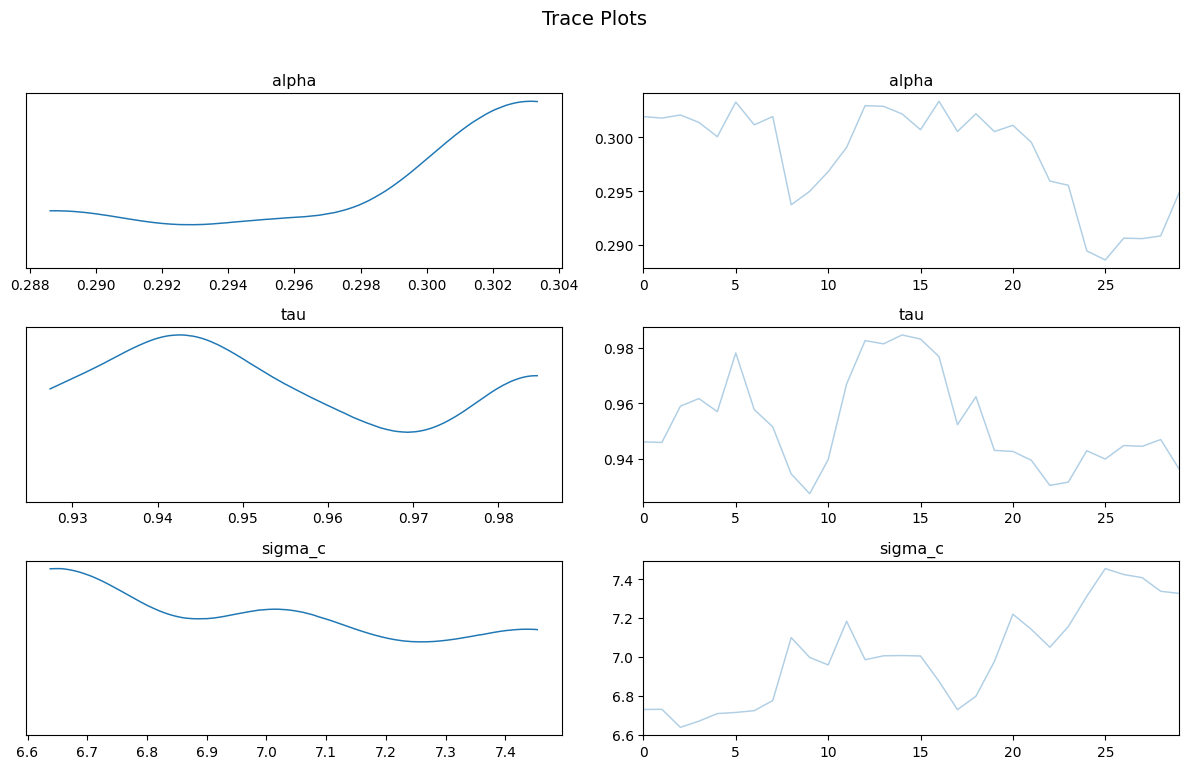

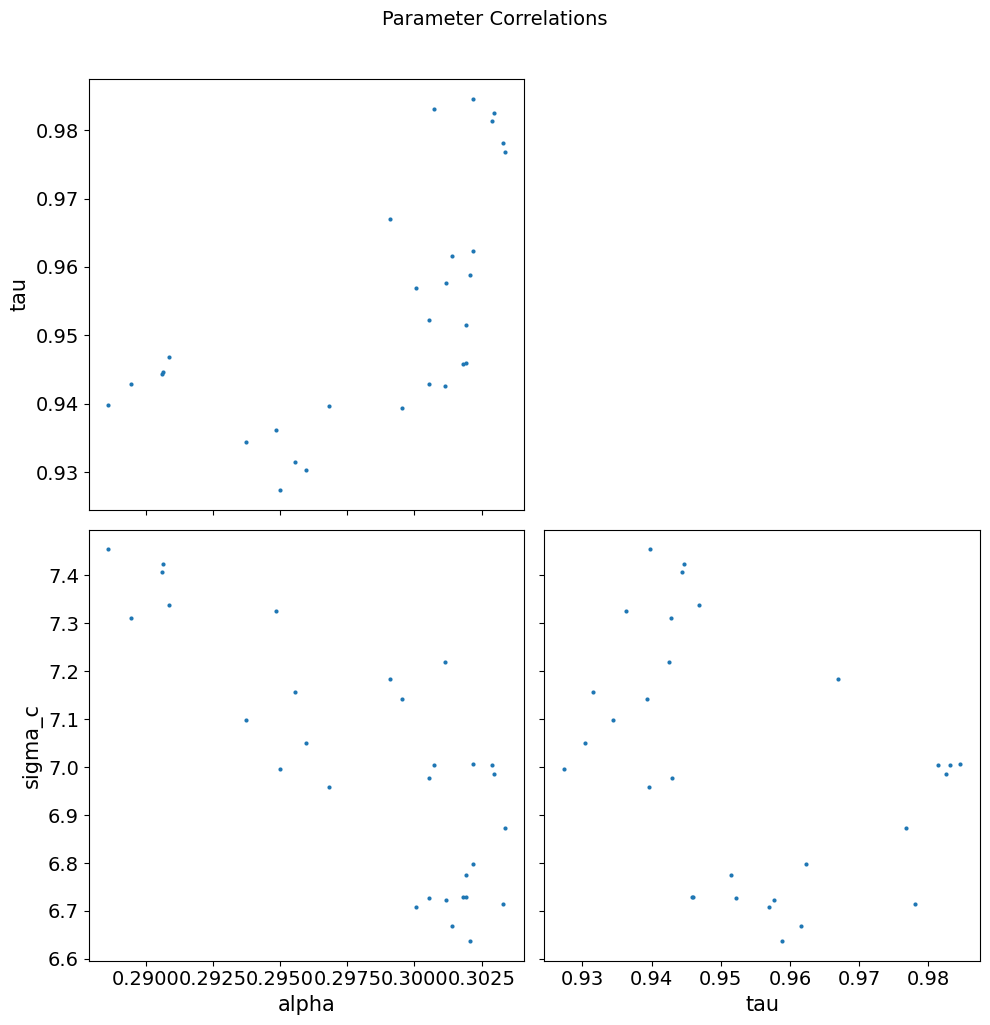

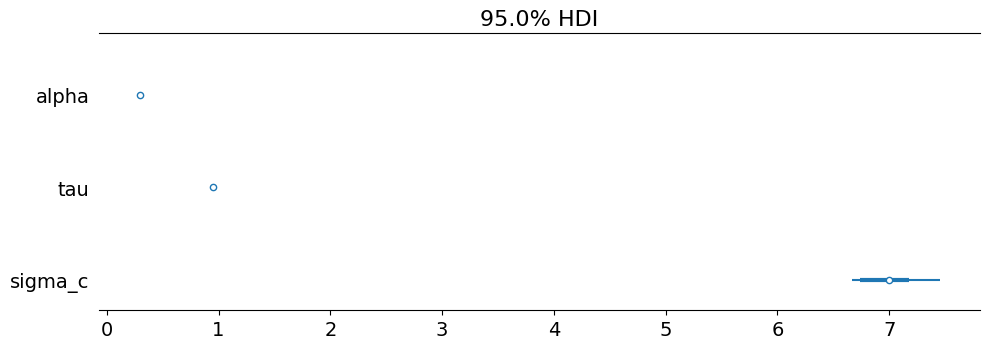

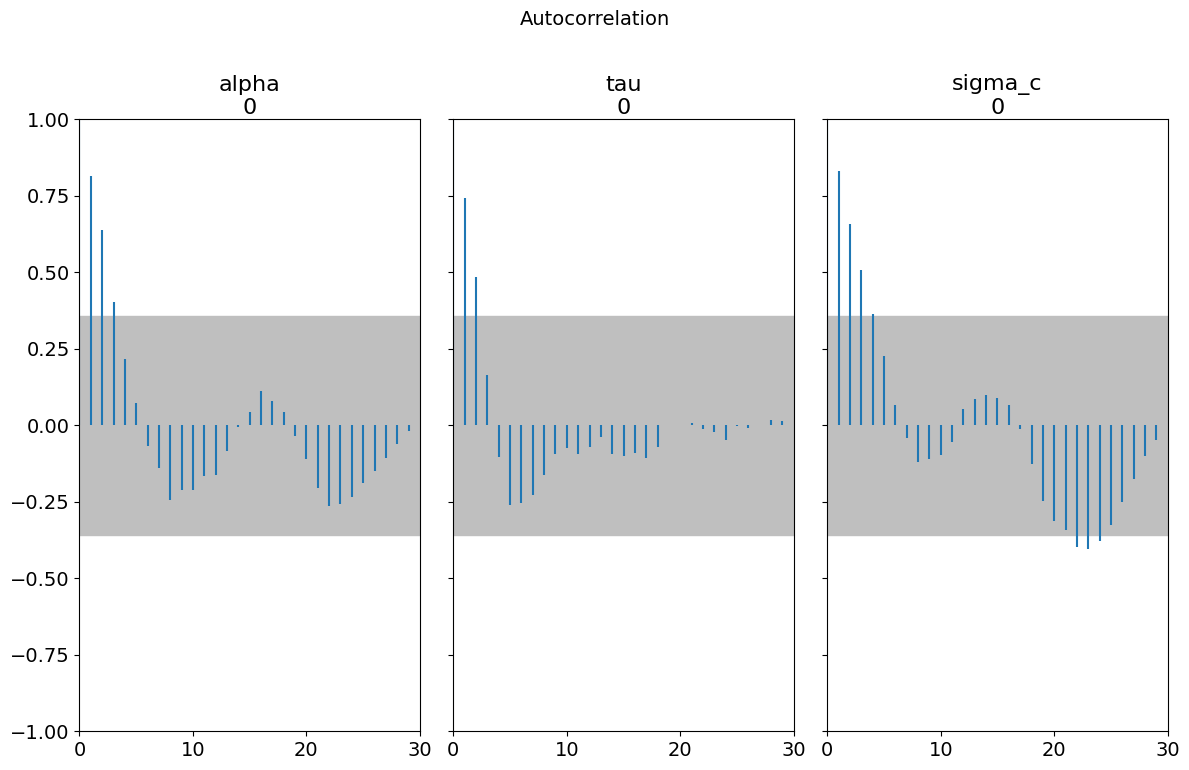

In [11]:
# ArviZ diagnostics
param_names = ["alpha", "tau", "sigma_c"]
display_arviz_diagnostics(result, param_names, fast_mode=FAST_MODE)

### 5.3 Glass Probability from Relaxation

P(glass) = P(α < 0.5) = 100.0%


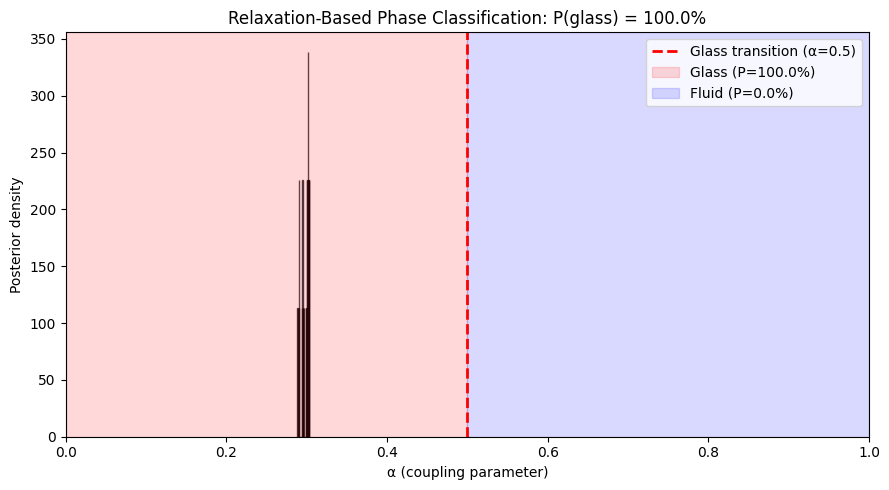

In [12]:
# Compute P(glass) = P(α < 0.5)
posterior = result.posterior_samples
alpha_samples = np.array(posterior["alpha"])

p_glass = np.mean(alpha_samples < 0.5)
print(f"P(glass) = P(α < 0.5) = {p_glass:.1%}")

# Plot histogram with glass/fluid classification
fig, ax = plt.subplots(figsize=(9, 5))

ax.hist(alpha_samples, bins=50, density=True, alpha=0.7, color="C0", edgecolor="black")
ax.axvline(0.5, color="red", linestyle="--", linewidth=2, label="Glass transition (α=0.5)")

ax.axvspan(0, 0.5, alpha=0.15, color="red", label=f"Glass (P={p_glass:.1%})")
ax.axvspan(0.5, 1.0, alpha=0.15, color="blue", label=f"Fluid (P={1-p_glass:.1%})")

ax.set_xlabel("α (coupling parameter)")
ax.set_ylabel("Posterior density")
ax.set_title(f"Relaxation-Based Phase Classification: P(glass) = {p_glass:.1%}")
ax.legend()
ax.set_xlim(0, 1)

plt.tight_layout()
display(fig)
plt.close(fig)

### 5.4 Posterior Predictive Check

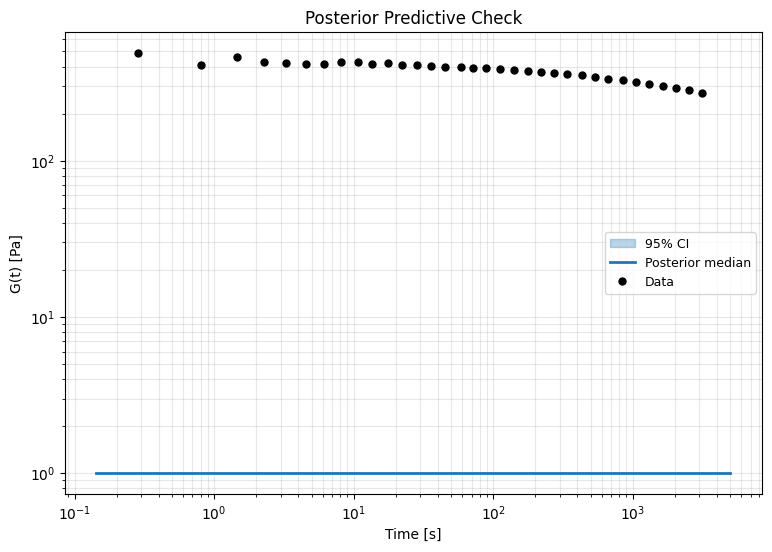

In [13]:
# Posterior predictive with 95% credible intervals
param_names = ["alpha", "tau", "sigma_c"]
posterior = result.posterior_samples

fig, ax = plot_posterior_predictive(
    time_3600, G_t_3600, model, result,
    test_mode="relaxation", param_names=param_names,
    log_scale=True,
    xlabel="Time [s]", ylabel="G(t) [Pa]",
    title="Posterior Predictive Check",
)
display(fig)
plt.close(fig)

### 5.5 Parameter Summary

In [14]:
# NLSQ vs Bayesian comparison table
print("Parameter Comparison: NLSQ vs Bayesian")
print("=" * 65)
print(f"{'Param':>10s}  {'NLSQ':>12s}  {'Bayes median':>14s}  {'95% CI':>22s}")
print("-" * 65)

for name in param_names:
    nlsq_val = model.parameters.get_value(name)
    bayes_samples = posterior[name]
    median = float(np.median(bayes_samples))
    lo = float(np.percentile(bayes_samples, 2.5))
    hi = float(np.percentile(bayes_samples, 97.5))
    print(f"{name:>10s}  {nlsq_val:12.4g}  {median:14.4g}  [{lo:.4g}, {hi:.4g}]")

Parameter Comparison: NLSQ vs Bayesian
     Param          NLSQ    Bayes median                  95% CI
-----------------------------------------------------------------
     alpha        0.2949          0.3005  [0.2892, 0.3033]
       tau        0.9362          0.9464  [0.9295, 0.9835]
   sigma_c         7.326           7.001  [6.66, 7.432]


## 6. Save Results

In [15]:
# Save results
output_dir = os.path.join("..", "outputs", "hl", "relaxation")
os.makedirs(output_dir, exist_ok=True)

# Save NLSQ point estimates
nlsq_params = {
    name: float(model.parameters.get_value(name))
    for name in ["alpha", "tau", "sigma_c"]
}
with open(os.path.join(output_dir, "nlsq_params_relaxation.json"), "w") as f:
    json.dump(nlsq_params, f, indent=2)

# Save aging sweep results
with open(os.path.join(output_dir, "aging_sweep_results.json"), "w") as f:
    json.dump({str(k): v for k, v in fit_results.items()}, f, indent=2)

# Save posterior samples
posterior_dict = {k: np.array(v).tolist() for k, v in posterior.items()}
with open(os.path.join(output_dir, "posterior_relaxation.json"), "w") as f:
    json.dump(posterior_dict, f)

print(f"Results saved to {output_dir}/")
print(f"  nlsq_params_relaxation.json: {len(nlsq_params)} parameters")
print(f"  aging_sweep_results.json: {len(fit_results)} aging times")
print(f"  posterior_relaxation.json: {len(alpha_samples)} draws")

gc.collect()

Results saved to ../outputs/hl/relaxation/
  nlsq_params_relaxation.json: 3 parameters
  aging_sweep_results.json: 5 aging times
  posterior_relaxation.json: 30 draws


53979

## Key Takeaways

1. **Incomplete relaxation** is the signature of the HL glass phase (α < 0.5) — stress blocks remain trapped, giving a non-zero long-time modulus.

2. **Aging increases glassiness**: As waiting time t_w increases, the coupling parameter α decreases, moving the material deeper into the glass phase.

3. **Relaxation probes different physics than flow curves**: While flow curves test steady-state yielding, relaxation tests the frozen stress distribution.

4. **P(glass) from relaxation** may differ from flow curve estimates due to:
   - Different strain amplitude regimes (linear vs nonlinear)
   - Protocol-specific sensitivities to model parameters

5. **Laponite clay** is a classic soft glassy material that clearly demonstrates the HL glass transition through aging.

### Physical Interpretation

| Observation | HL Interpretation |
|-------------|-------------------|
| G(t) decays slowly | Low α, stress blocks trapped |
| G(t → ∞) > 0 | Glass phase, frozen residual stress |
| Older samples decay slower | Lower α with aging |
| Initial modulus G(0) | Related to σ_c and elastic response |

### Next Steps

- **NB 03**: Creep (delayed yielding near yield stress)
- **NB 04**: SAOS (frequency-dependent moduli)
- **NB 05**: Startup (stress overshoot dynamics)

## Further Reading

- [Hébraud-Lequeux Model Handbook](../../docs/source/models/hl/hebraud_lequeux.rst)
- Hébraud, P. & Lequeux, F. (1998). Mode-coupling theory for the pasty rheology of soft glassy materials. *Phys. Rev. Lett.*, 81, 2934. https://doi.org/10.1103/PhysRevLett.81.2934
- Derec, C., Ajdari, A., & Lequeux, F. (2001). Rheology and aging: A simple approach. *Eur. Phys. J. E*, 4, 355–361. https://doi.org/10.1007/s101890170118
- Fielding, S. M., Sollich, P., & Cates, M. E. (2000). Aging and rheology in soft materials. *J. Rheol.*, 44(2), 323-369. https://doi.org/10.1122/1.551088